In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
import math
#+++++++++++++++++++++++++++++++++++++++++++++++++ PREPROCESSING ++++++++++++++++++++++++++++++++++++++++++++++

ice_thickness = pd.read_csv('../data/ice_thickness.csv')
ice_velocity = pd.read_csv('../data/ice_velocity.csv')

#removing any rows with ice_thickness = 0 (looking only at data points with ice for this analysis)
ice_thickness = ice_thickness[ice_thickness['ice_thickness']!=0]

#removing any rows with ice_velocity -1
ice_velocity = ice_velocity[ice_velocity['ice_velocity']!=-1]

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse):
    target_min = df['ice_thickness'].min()
    target_max = df['ice_thickness'].max()

    return scaled_rmse * (target_max - target_min)


def replace_with_abs(df, columns):
    new_df = df.copy()
    for column in columns:
        new_df[column] = new_df[column].abs()
    return new_df



In [16]:
#+++++++++++++++++++++++++++++++++++++++++++++ LINEAR REGRESSION +++++++++++++++++++++++++++++++++++++++++++

#dataframe must already be scaled, and if applicable have the xy values made absolute 
def doLinReg(preprocessed_df, seed, n_runs):
    scores = []
    coefficients = []
    RMSEs = []
    # Run the linear regression 30 times
    for i in range(n_runs):
        randomState = i*seed
        # Split the data into training and testing sets
        X = preprocessed_df.iloc[:, :-1] #selects all but the last column 
        y = preprocessed_df.iloc[:, -1] #selects only the last column
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        # Create and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Store the score, coefficients, and rmse
        scores.append(model.score(X_test, y_test))
        coefficients.append(model.coef_)
        y_predicted = model.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, y_predicted)) #calculate the root mean squared error
        RMSEs.append(rmse)

    # Calculate the average score and coefficients
    average_score = np.mean(scores)
    average_coefficients = np.mean(coefficients, axis=0)
    average_rmse = np.mean(RMSEs)

    # Output the results
    print(f"Linreg Average Score: {average_score:,.4f}")
    print("Average Coefficients:", average_coefficients)
    print(f"Average Unscaled RMSE: {unscale_rmse(average_rmse):,.2f}")
    return average_coefficients

In [20]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
#preprocessed df must already be scaled and have the abs for xy if applicable 
def doRandomForest(preprocessed_df, seed, n_runs):
    scores = []
    RMSEs = []
    importances = []
    
    for i in range(n_runs):
        randomState = i*seed
        X = preprocessed_df.iloc[:, :-1] #selects all but the last column 
        y = preprocessed_df.iloc[:, -1] #selects only the last column
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = RandomForestRegressor(random_state = randomState)
        model.fit(X_train, y_train)
        
        scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_predicted = model.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, y_predicted)) #calculate the root mean squared error
        RMSEs.append(rmse)
        
        average_score = np.mean(scores)
        average_importances = np.mean(importances, axis=0)
        average_rmse = np.mean(RMSEs)
        
    print(f"Random Forest Average Score: {average_score:,.4f}")
    print("Average Importances:", average_importances)
    print(f"Average Unscaled RMSE: {unscale_rmse(average_rmse):,.2f}")
    return average_importances

In [21]:
##+++++++++++++++++++++++++++++++++++++++++++++ ICE THICKNESS ++++++++++++++++++++++++++++++++++++++++++++
print("REGULAR LINREG")
seed = 101
scaled_df = scale(ice_thickness)
average_coef_IT = doLinReg(scaled_df, seed, 30)

print("\nABS LINREG")
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_average_coef_IT = doLinReg(abs_scaled_df, seed, 30)

print("\nREGULAR RF")
average_importances_IT = doRandomForest(scaled_df, seed, 30)

print("\nABS RF")
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_average_importances_IT = doRandomForest(abs_scaled_df, seed, 30)


REGULAR LINREG
Linreg Average Score: 0.6716
Average Coefficients: [-0.03393994 -0.17595196  0.12930657 -0.88062739  0.33196438]


NameError: name 'df' is not defined

In [19]:
##+++++++++++++++++++++++++++++++++++++++++++++ ICE VELOCITY ++++++++++++++++++++++++++++++++++++++++++++
print("REGULAR LINREG")
seed = 101
scaled_df = scale(ice_velocity)
average_coef_IV = doLinReg(scaled_df, seed, 30)

print("\nABS LINREG")
abs_df = replace_with_abs(ice_velocity, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_average_coef_IV = doLinReg(abs_scaled_df, seed, 30)

print("\nREGULAR RF")
average_importances_IV = doRandomForest(scaled_df, seed, 30)

print("\nABS RF")
abs_df = replace_with_abs(ice_velocity, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_average_importances_IV = doRandomForest(abs_scaled_df, seed, 30)


REGULAR LINREG
Linreg Average Score: 0.1131
Average Coefficients: [ 0.05070234  0.01485978  0.22482359  0.06979412 -0.05801929]


NameError: name 'df' is not defined

In [82]:
#+++++++++++++++++++++++++++++++++++++++++ GETTING DFS FOR PLOTTING ++++++++++++++++++++++++++++++++++++++
cols = ['x-axis', 'y-axis', "precipitation", "air_temp", "ocean_temp"]


##+++++++++++++++++++++++++++++++++++++++++++++ ICE THICKNESS ++++++++++++++++++++++++++++++++++++++++++++
linreg_coef_IT = pd.DataFrame(columns=cols)
linreg_coef_IT.loc[len(linreg_coef)] = average_coef_IT

abs_linreg_coef_IT = pd.DataFrame(columns=cols)
abs_linreg_coef_IT.loc[len(abs_linreg_coef)] = abs_average_coef_IT

rf_feature_importance_IT = pd.DataFrame(columns=cols)
rf_feature_importance_IT.loc[len(rf_feature_importance)] = average_importances_IT

abs_rf_feature_importance_IT = pd.DataFrame(columns=cols)
abs_rf_feature_importance_IT.loc[len(abs_rf_feature_importance)] = abs_average_importances_IT


##+++++++++++++++++++++++++++++++++++++++++++++ ICE VELOCITY ++++++++++++++++++++++++++++++++++++++++++++
linreg_coef_IV = pd.DataFrame(columns=cols)
linreg_coef_IV.loc[len(linreg_coef)] = average_coef_IV

abs_linreg_coef_IV = pd.DataFrame(columns=cols)
abs_linreg_coef_IV.loc[len(abs_linreg_coef)] = abs_average_coef_IV

rf_feature_importance_IV = pd.DataFrame(columns=cols)
rf_feature_importance_IV.loc[len(rf_feature_importance)] = average_importances_IV

abs_rf_feature_importance_IV = pd.DataFrame(columns=cols)
abs_rf_feature_importance_IV.loc[len(abs_rf_feature_importance)] = abs_average_importances_IV


In [87]:
def plot_coefficients(coef_df, title):
    for column in coef_df.columns: 
            coef_df[column] = coef_df[column].abs()
            
    transposed_linreg_coef = coef_df.T
    transposed_linreg_coef.reset_index(inplace=True)
    transposed_linreg_coef.columns = ['Feature', 'Coefficient']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_linreg_coef['Feature'], transposed_linreg_coef['Coefficient'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [88]:
def plot_importance(importance_df, title):
    for column in importance_df.columns: 
            importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

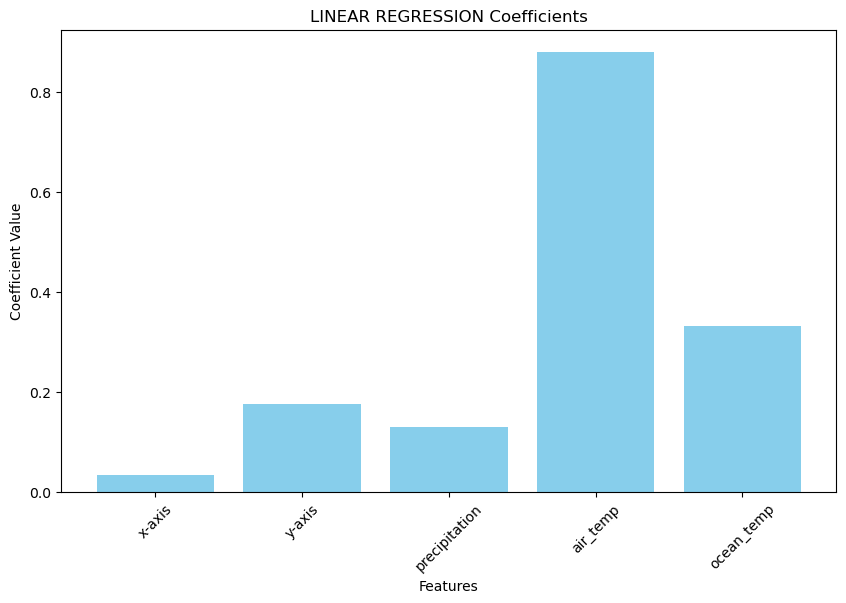

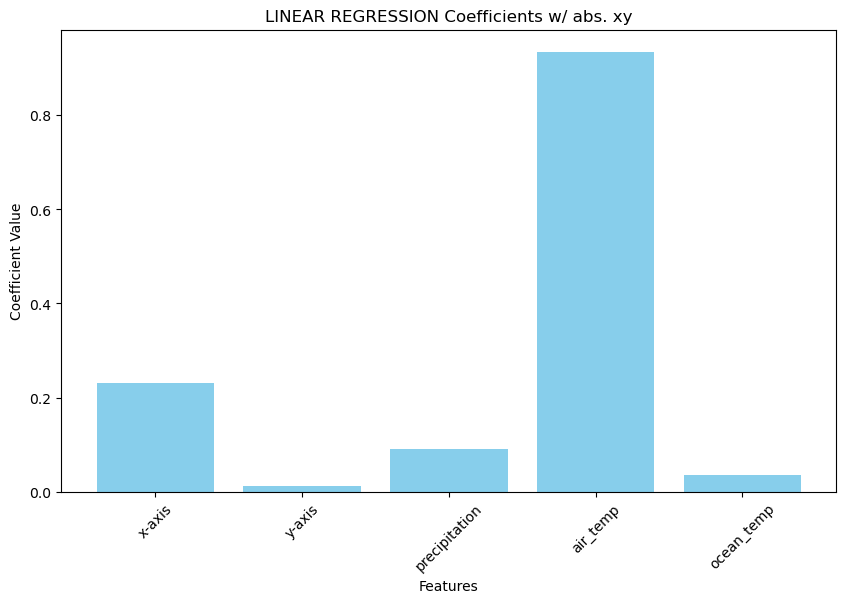

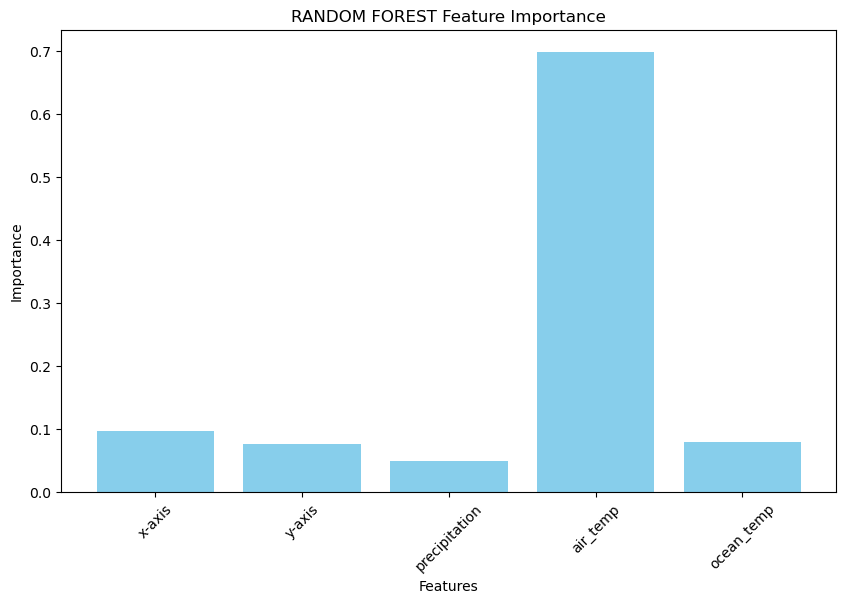

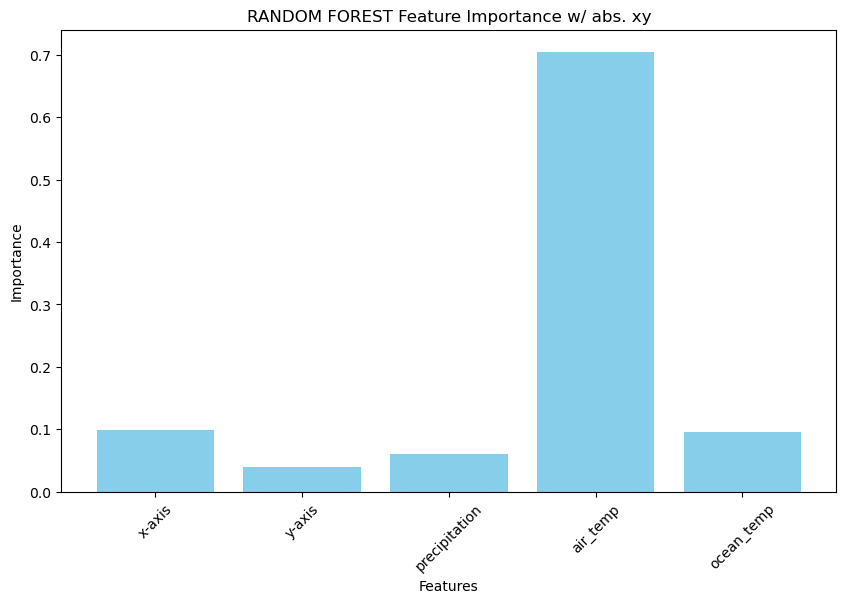

In [85]:
##+++++++++++++++++++++++++++++++++++++++++++++ PLOT ICE THICKNESS ++++++++++++++++++++++++++++++++++++++++++++
plot_coefficients(linreg_coef_IT, "LINEAR REGRESSION Coefficients")
plot_coefficients(abs_linreg_coef_IT, "LINEAR REGRESSION Coefficients w/ abs. xy")
plot_importance(rf_feature_importance_IT, "RANDOM FOREST Feature Importance")
plot_importance(abs_rf_feature_importance_IT, "RANDOM FOREST Feature Importance w/ abs. xy")

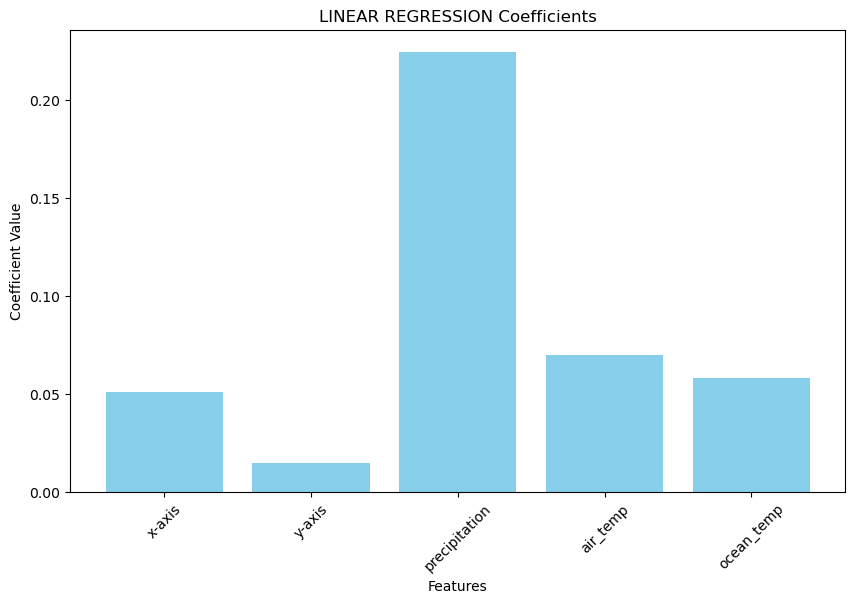

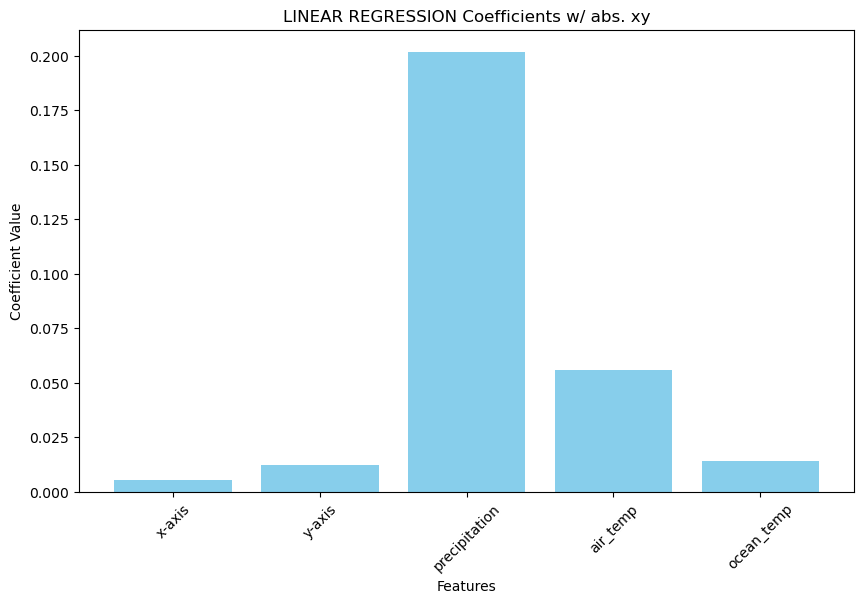

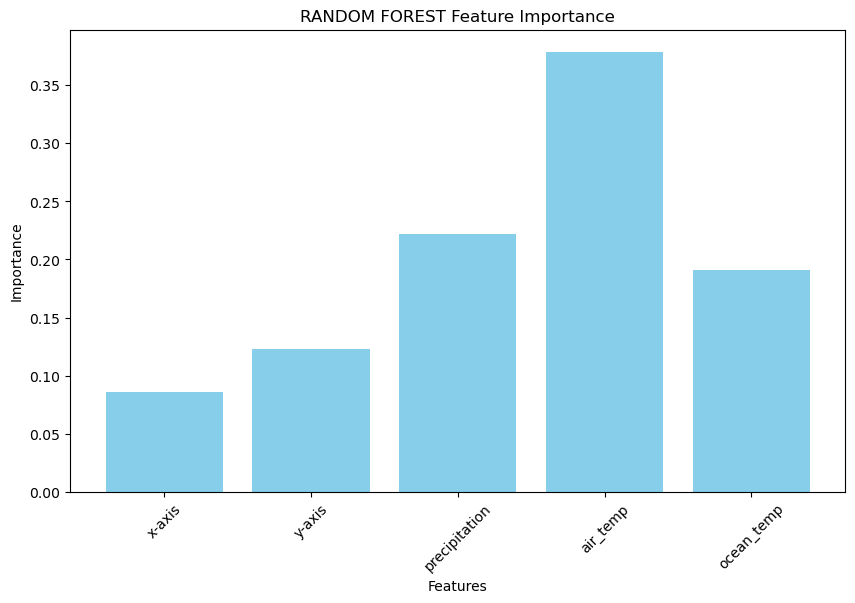

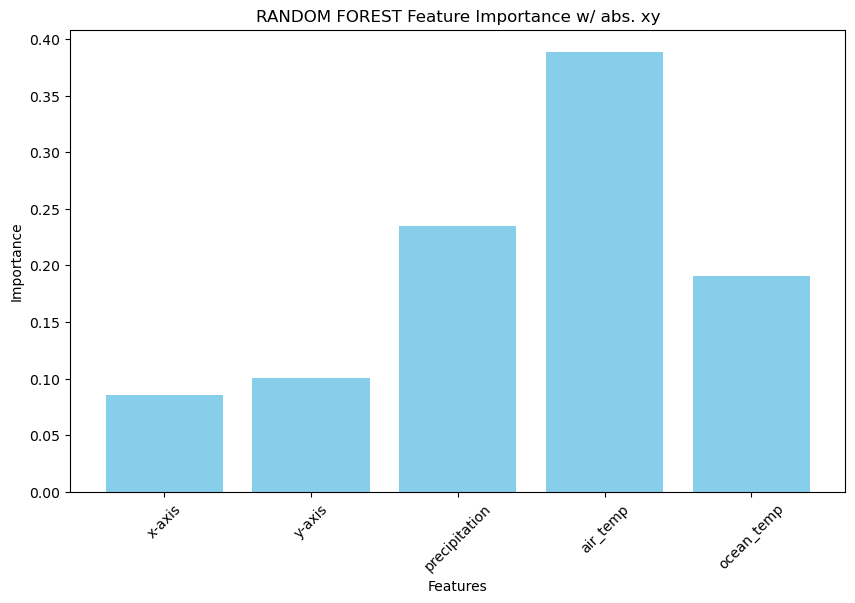

In [86]:
##+++++++++++++++++++++++++++++++++++++++++++++ PLOT ICE VELOCITY ++++++++++++++++++++++++++++++++++++++++++++
plot_coefficients(linreg_coef_IV, "LINEAR REGRESSION Coefficients")
plot_coefficients(abs_linreg_coef_IV, "LINEAR REGRESSION Coefficients w/ abs. xy")
plot_importance(rf_feature_importance_IV, "RANDOM FOREST Feature Importance")
plot_importance(abs_rf_feature_importance_IV, "RANDOM FOREST Feature Importance w/ abs. xy")